# RNA-ADT: scButterfly-B

The following tutorial demonstrate how to use scButterfly-B to make translation between RNA and ADT data.

We special design pre-processing and model network for ADT data, and keep RNA part consistent with the [translation between RNA and ATAC](../index.rst#translation-between-scrna-seq-and-scatac-seq-paired-data)

There are three part of this tutorial:

* **Load data and data pre-processing**. This part will tell you how to load and pre-process scRNA-seq and scADT-seq data for scButterfly model. 

* **Construct and train a scButterfly model**. This part will tell you how to generate and train a scButterfly model correctly.

* **Get prediction and evaluate the performance**. This part will tell you how to get prediction from scButterfly model and evaluate the performance of prediction.

In [1]:
import scanpy as sc
import pandas as pd
from scipy.sparse import csr_matrix

## Load data and data pre-processing

Here we use the adult human bone marrow mononuclear cells (BMMC) as example. ([Malte Luecken, et al., 2021](https://datasets-benchmarks-proceedings.neurips.cc/paper/2021/hash/158f3069a435b314a80bdcb024f8e422-Abstract-round2.html))

In [2]:
ADT_data = sc.read_h5ad('bmmc_ADT_cnt.h5ad')
RNA_data = sc.read_h5ad('bmmc_RNA_cnt.h5ad')
ADT_data.X = csr_matrix(ADT_data.X)
RNA_data.X = csr_matrix(RNA_data.X)

In [3]:
RNA_data

AnnData object with n_obs × n_vars = 90261 × 13953
    obs: 'GEX_n_genes_by_counts', 'GEX_pct_counts_mt', 'GEX_size_factors', 'GEX_phase', 'ADT_n_antibodies_by_counts', 'ADT_total_counts', 'ADT_iso_count', 'cell_type', 'batch', 'ADT_pseudotime_order', 'GEX_pseudotime_order', 'Samplename', 'Site', 'DonorNumber', 'Modality', 'VendorLot', 'DonorID', 'DonorAge', 'DonorBMI', 'DonorBloodType', 'DonorRace', 'Ethnicity', 'DonorGender', 'QCMeds', 'DonorSmoker', 'is_train'
    var: 'feature_types', 'gene_id'
    uns: 'dataset_id', 'genome', 'organism'
    obsm: 'ADT_X_pca', 'ADT_X_umap', 'ADT_isotype_controls', 'GEX_X_pca', 'GEX_X_umap'
    layers: 'counts'

In [4]:
ADT_data

AnnData object with n_obs × n_vars = 90261 × 134
    obs: 'GEX_n_genes_by_counts', 'GEX_pct_counts_mt', 'GEX_size_factors', 'GEX_phase', 'ADT_n_antibodies_by_counts', 'ADT_total_counts', 'ADT_iso_count', 'cell_type', 'batch', 'ADT_pseudotime_order', 'GEX_pseudotime_order', 'Samplename', 'Site', 'DonorNumber', 'Modality', 'VendorLot', 'DonorID', 'DonorAge', 'DonorBMI', 'DonorBloodType', 'DonorRace', 'Ethnicity', 'DonorGender', 'QCMeds', 'DonorSmoker', 'is_train'
    var: 'feature_types', 'gene_id'
    uns: 'dataset_id', 'genome', 'organism'
    obsm: 'ADT_X_pca', 'ADT_X_umap', 'ADT_isotype_controls', 'GEX_X_pca', 'GEX_X_umap'
    layers: 'counts'

First, we pre-process data using ``RNA_data_preprocessing`` in ``scButterfly.data_processing`` for RNA-seq pre-processing. For ADT-seq, we choose a centered log-ratio (CLR) transformation for each cell, which could be write as:

$$
CLR(x) = [ln(\frac{x_1}{g(x)}), ln(\frac{x_2}{g(x)}), ..., ln(\frac{x_n}{g(x)})]
$$

$g(x)$ is the geometric mean of $x$.

In [5]:
from scButterfly.data_processing import RNA_data_preprocessing, CLR_transform

In [6]:
RNA_data = RNA_data_preprocessing(
    RNA_data,
    normalize_total=True,
    log1p=True,
    use_hvg=True,
    n_top_genes=3000,
    save_data=False,
    file_path=None,
    logging_path=None
    )
ADT_data = CLR_transform(ADT_data)[0]

[INFO] RNA preprocessing: normalize size factor.
[INFO] RNA preprocessing: log transform RNA data.
[INFO] RNA preprocessing: choose top 3000 genes for following training.


In [7]:
from scButterfly.split_datasets import *
id_list = five_fold_split_dataset(RNA_data, ADT_data, seed=19191)
train_id, validation_id, test_id = id_list[0]
train_id_r = train_id.copy()
train_id_a = train_id.copy()
validation_id_r = validation_id.copy()
validation_id_a = validation_id.copy()
test_id_r = test_id.copy()
test_id_a = test_id.copy()

## Construct and train a scButterfly model

We could load scButterfly model for RNA and ADT data from ``scButterfly.train_model_cite``

<div class="alert warning">
<p>

**Warning**

We propose you to ensure that the settings of parameters for pre-processing, construct model and train model are same with here, while feel free to decide path for logging and model output.

</p>
</div>

In [8]:
from scButterfly.train_model_cite import Model
import torch
import torch.nn as nn

In [9]:
RNA_input_dim = len([i for i in RNA_data.var['highly_variable'] if i])
ADT_input_dim = ADT_data.X.shape[1]

R_kl_div = 1 / RNA_input_dim * 20
A_kl_div = 1 / 150
kl_div = R_kl_div + A_kl_div

In [10]:
model = Model(
    R_encoder_nlayer = 2, 
    A_encoder_nlayer = 2,
    R_decoder_nlayer = 2, 
    A_decoder_nlayer = 2,
    R_encoder_dim_list = [RNA_input_dim, 256, 128],
    A_encoder_dim_list = [ADT_input_dim, 128, 128],
    R_decoder_dim_list = [128, 256, RNA_input_dim],
    A_decoder_dim_list = [128, 128, ADT_input_dim],
    R_encoder_act_list = [nn.LeakyReLU(), nn.LeakyReLU()],
    A_encoder_act_list = [nn.LeakyReLU(), nn.LeakyReLU()],
    R_decoder_act_list = [nn.LeakyReLU(), nn.LeakyReLU()],
    A_decoder_act_list = [nn.LeakyReLU(), nn.LeakyReLU()],
    translator_embed_dim = 128, 
    translator_input_dim_r = 128,
    translator_input_dim_a = 128,
    translator_embed_act_list = [nn.LeakyReLU(), nn.LeakyReLU(), nn.LeakyReLU()],
    discriminator_nlayer = 1,
    discriminator_dim_list_R = [128],
    discriminator_dim_list_A = [128],
    discriminator_act_list = [nn.Sigmoid()],
    dropout_rate = 0.1,
    R_noise_rate = 0.5,
    A_noise_rate = 0,
    chrom_list = [],
    logging_path = None,
    RNA_data = RNA_data,
    ATAC_data = ADT_data
)

Train a scButterfly model.

In [11]:
model.train(
    R_encoder_lr = 0.001,
    A_encoder_lr = 0.001,
    R_decoder_lr = 0.001,
    A_decoder_lr = 0.001,
    R_translator_lr = 0.001,
    A_translator_lr = 0.001,
    translator_lr = 0.001,
    discriminator_lr = 0.005,
    R2R_pretrain_epoch = 100,
    A2A_pretrain_epoch = 100,
    lock_encoder_and_decoder = False,
    translator_epoch = 200,
    patience = 50,
    batch_size = 64,
    r_loss = nn.MSELoss(size_average=True),
    a_loss = nn.MSELoss(size_average=True),
    d_loss = nn.BCELoss(size_average=True),
    loss_weight = [1, 2, 1, R_kl_div, A_kl_div, kl_div],
    train_id_r = train_id_r,
    train_id_a = train_id_a,
    validation_id_r = validation_id_r, 
    validation_id_a = validation_id_a, 
    output_path = None,
    seed = 19193,
    kl_mean = True,
    R_pretrain_kl_warmup = 50,
    A_pretrain_kl_warmup = 50,
    translation_kl_warmup = 50,
    load_model = None,
    logging_path = None
)

[INFO] Trainer: RNA pretraining ...
RNA pretrain: 100%|█████████████████████| 100/100 [16:20<00:00,  9.80s/it, train=0.0494, val=0.0520]
[INFO] Trainer: ADT pretraining ...
ADT pretrain: 100%|█████████████████████| 100/100 [14:56<00:00,  8.97s/it, train=0.0581, val=0.0814]
[INFO] Trainer: Combine training ...
Combine training:  30%|████▋           | 59/200 [45:17<1:48:15, 46.07s/it, train=0.5115, val=0.5123]


## Get prediction and evaluate the performance

You could get cross-modal predictions using ``model.test`` using ``return_predict=True``. We also provided more information metrics in this function, see in [API](../../API/index.html).

In [12]:
A2R_predict, R2A_predict = model.test(
    test_id_r = test_id_r,
    test_id_a = test_id_a, 
    model_path = None,
    load_model = False,
    output_path = None,
    test_cluster = False,
    test_figure = False,
    output_data = False,
    return_predict = True
)

[INFO] Tester: get predicting ...
ATAC to RNA predicting...: 100%|██████████████████████████████████| 283/283 [00:04<00:00, 66.19it/s]
[INFO] Tester: calculate neighbors graph for following test ...


Here we draw the [t-SNE](https://jmlr.org/papers/v9/vandermaaten08a.html) embeddings and measure the ARI, AMI, NMI, and HOM.

In [13]:
from scButterfly.calculate_cluster import calculate_cluster_index

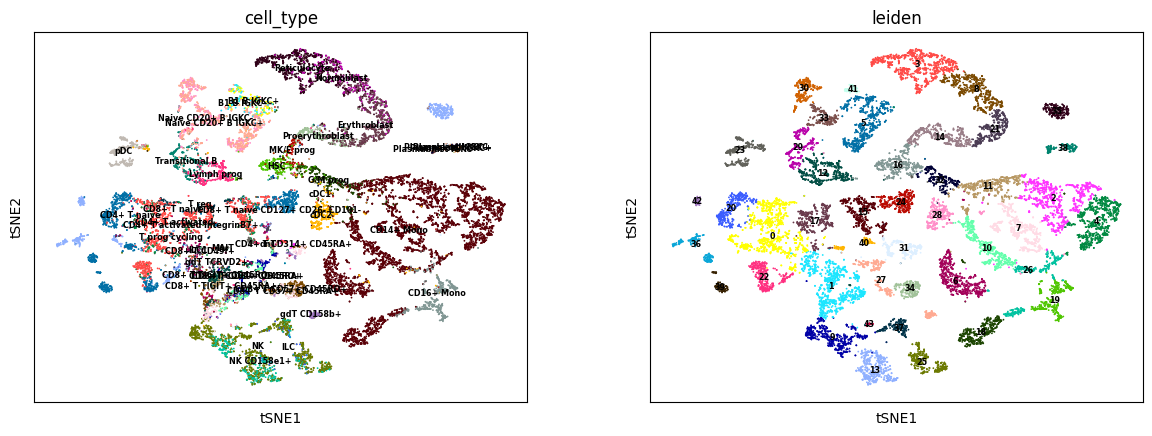

In [14]:
sc.tl.tsne(A2R_predict)
sc.tl.leiden(A2R_predict)
sc.pl.tsne(A2R_predict, color=['cell_type', 'leiden'], legend_loc='on data', legend_fontsize='xx-small')

In [15]:
ARI, AMI, NMI, HOM = calculate_cluster_index(A2R_predict)
print('ADT to RNA:\nARI: %.3f, \tAMI: %.3f, \tNMI: %.3f, \tHOM: %.3f' % (ARI, AMI, NMI, HOM))

ADT to RNA:
ARI: 0.270, 	AMI: 0.659, 	NMI: 0.664, 	HOM: 0.726, 	COM: 0.612


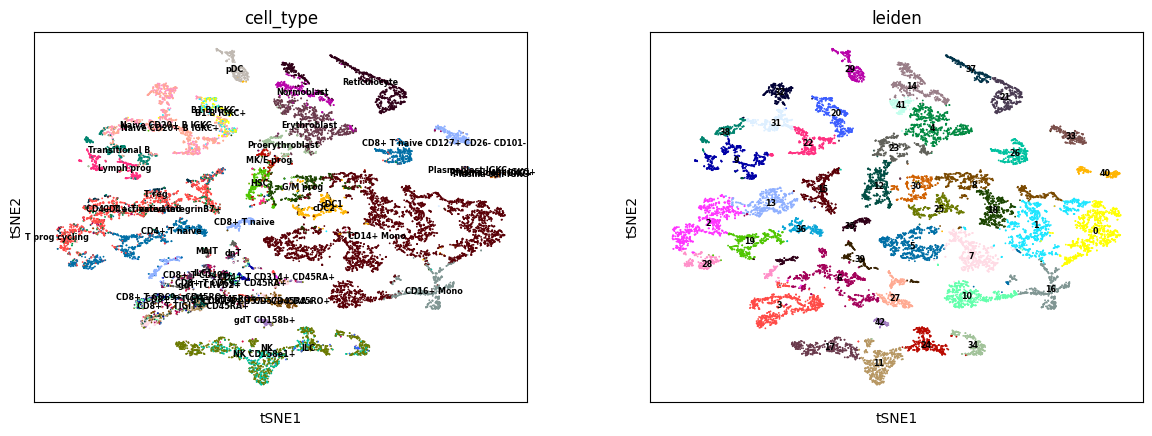

In [16]:
sc.tl.tsne(R2A_predict)
sc.tl.leiden(R2A_predict)
sc.pl.tsne(R2A_predict, color=['cell_type', 'leiden'], legend_loc='on data', legend_fontsize='xx-small')

In [17]:
ARI, AMI, NMI, HOM = calculate_cluster_index(R2A_predict)
print('RNA to ADT:\nARI: %.3f, \tAMI: %.3f, \tNMI: %.3f, \tHOM: %.3f' % (ARI, AMI, NMI, HOM))

RNA to ADT:
ARI: 0.295, 	AMI: 0.684, 	NMI: 0.689, 	HOM: 0.756, 	COM: 0.632
